In [1]:
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.StretchedExponential import SEInvImpulseProblem, SESurvey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver

In [2]:
# figdir = "../../docs/figures/"

In [3]:
from simpegEMIP.TDEM import Problem3D_e, Problem3DEM_e, Rx, Survey

In [4]:
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
cs, ncx, ncz, npad = 10., 10, 40, 20
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    

In [5]:
from simpegEMIP.TDEM.Utils import get_dobs_pn
import matplotlib 
matplotlib.rcParams["font.size"] = 16
matplotlib.rcParams["image.cmap"] = "RdBu_r"

In [6]:
radius = 13.
moment = np.pi*radius**2 / 1e12

In [7]:
cs, ncx, ncz, npad = 25., 25, 40, 20
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
dz = 50.
sig_1 = 1e-4
data_list_siginf_sig_1_r_small = []
data_em_list_siginf_sig_1_r_small = []
data_ip_list_siginf_sig_1_r_small = []
for i in range(9):
    sig_2 = sig_1*1000.
    sigmaInf = np.ones(mesh.nC) * sig_1
    airind = mesh.gridCC[:,2]>0.
    blkind  = np.logical_and(mesh.gridCC[:,0]<50., (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-100-dz*i)&(mesh.gridCC[:,2]<-dz*i))
    sigmaInf[airind] = 1e-8
    sigmaInf[blkind] = sig_2
    eta_CC, tau_CC, c_CC = 0.1, 0.001, 0.7
    print (eta_CC, tau_CC, c_CC)
    eta = np.zeros(mesh.nC)
    eta[blkind] = eta_CC
    tau = np.ones(mesh.nC) * tau_CC
    c = np.ones(mesh.nC) * c_CC 

    rx_emip = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_emip = EM.TDEM.Src.CircularLoop([rx_emip], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_emip = Survey([src_emip])
    prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
    prb_emip.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb_emip.Solver = PardisoSolver
    prb_emip.pair(survey_emip)
    m = np.r_[sigmaInf, eta, tau, c]
    data = survey_emip.dpred(m)
    data_list_siginf_sig_1_r_small.append(data) 
    
    rx_em = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_em = EM.TDEM.Src.CircularLoop([rx_em], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_em = Survey([src_em])
    prb_em = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta*0., tau=tau, c=c)
    prb_em.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb_em.Solver = PardisoSolver
    prb_em.pair(survey_em)
    m = np.r_[sigmaInf, eta, tau, c]
    data_em = survey_em.dpred(m)
    data_em_list_siginf_sig_1_r_small.append(data_em) 
    data_ip_list_siginf_sig_1_r_small.append(data - data_em)

0.1 0.001 0.7


/Users/sgkang/Projects/simpeg/SimPEG/Props.py:399: UserWarning: Cannot add model as there are no active mappings, choose from: ['cMap', 'etaMap', 'rhoMap', 'sigmaInfMap', 'sigmaMap', 'tauMap']
  "', '".join(self._all_map_names)


0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7


Text(0.5,100,'$\\sigma_{half}$=1e-04 S/m')

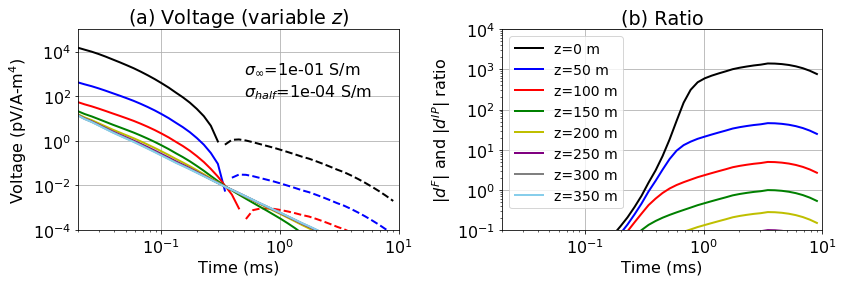

In [8]:
depths = abs(np.arange(9)*dz)
fig = plt.figure(figsize = (12, 4))
ax = plt.subplot(121)
ax1 = plt.subplot(122)
legends = [("z=%.0f m")%(depth) for depth in depths]
ms = 1e3
colors = ["k", "b", "r", "g", 'y', 'purple', 'grey', 'skyblue', 'seagreen']
for i in range(8):
    data_p, data_n = get_dobs_pn(data_list_siginf_sig_1_r_small[i].flatten()/moment)
    ax.loglog(rx_emip.times*ms, data_n, linestyle='-', color=colors[i], lw=2)
    ax.loglog(rx_emip.times*ms, data_p, linestyle='--', color=colors[i], lw=2)
for i in range(8):
    ax1.loglog(rx_emip.times*ms, abs(data_ip_list_siginf_sig_1_r_small[i].flatten()/data_em_list_siginf_sig_1_r_small[i].flatten()), linestyle='-', color=colors[i], lw=2)
ax1.legend(legends, fontsize=14)
for ax_temp in [ax, ax1]:
    ax_temp.set_xlabel("Time (ms)")        
    ax_temp.set_xlim(2e-5*ms, 0.01*ms)
    ax_temp.grid()
ax.set_ylabel("Voltage (pV/A-m$^4$)")    
ax1.set_ylabel('$|d^{F}|$ and $|d^{IP}|$ ratio')

ax.set_ylim(1e-4, 1e5)
ax1.set_ylim(1e-1, 1e4)
plt.tight_layout()    
ax.set_title("(a) Voltage (variable $z$)")
ax1.set_title("(b) Ratio")
ax.text(0.5, 1e3, ("$\sigma_{\infty}$=%.0e S/m")%(1e-1))
ax.text(0.5, 1e2, ("$\sigma_{half}$=%.0e S/m")%(1e-4))
# fig.savefig(figdir+"data_targetsize_1", dpi=300)

In [9]:
cs, ncx, ncz, npad = 5., 25, 60, 25
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
dzs = [10, 20, 30, 60, 100]
sig_1 = 1e-4
data_list_siginf_sig_1_r_small_h = []
data_em_list_siginf_sig_1_r_small_h = []
data_ip_list_siginf_sig_1_r_small_h = []
for dz in dzs:
    sig_2 = sig_1*1000.
    sigmaInf = np.ones(mesh.nC) * sig_1
    airind = mesh.gridCC[:,2]>0.
    blkind  = np.logical_and(mesh.gridCC[:,0]<50., (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-100-dz)&(mesh.gridCC[:,2]<-100))
    sigmaInf[airind] = 1e-8
    sigmaInf[blkind] = sig_2
    eta_CC, tau_CC, c_CC = 0.1, 0.001, 0.7
    print (eta_CC, tau_CC, c_CC)
    eta = np.zeros(mesh.nC)
    eta[blkind] = eta_CC
    tau = np.ones(mesh.nC) * tau_CC
    c = np.ones(mesh.nC) * c_CC 

    rx_emip = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_emip = EM.TDEM.Src.CircularLoop([rx_emip], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_emip = Survey([src_emip])
    prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
    prb_emip.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb_emip.Solver = PardisoSolver
    prb_emip.pair(survey_emip)
    m = np.r_[sigmaInf, eta, tau, c]
    data = survey_emip.dpred(m)
    data_list_siginf_sig_1_r_small_h.append(data) 
    
    rx_em = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_em = EM.TDEM.Src.CircularLoop([rx_em], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_em = Survey([src_em])
    prb_em = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta*0., tau=tau, c=c)
    prb_em.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb_em.Solver = PardisoSolver
    prb_em.pair(survey_em)
    m = np.r_[sigmaInf, eta, tau, c]
    data_em = survey_em.dpred(m)
    data_em_list_siginf_sig_1_r_small_h.append(data_em) 
    data_ip_list_siginf_sig_1_r_small_h.append(data - data_em)

0.1 0.001 0.7


/Users/sgkang/Projects/simpeg/SimPEG/Props.py:399: UserWarning: Cannot add model as there are no active mappings, choose from: ['cMap', 'etaMap', 'rhoMap', 'sigmaInfMap', 'sigmaMap', 'tauMap']
  "', '".join(self._all_map_names)


0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7
0.1 0.001 0.7


Text(0.5,100,'$\\sigma_{half}$=1e-04 S/m')

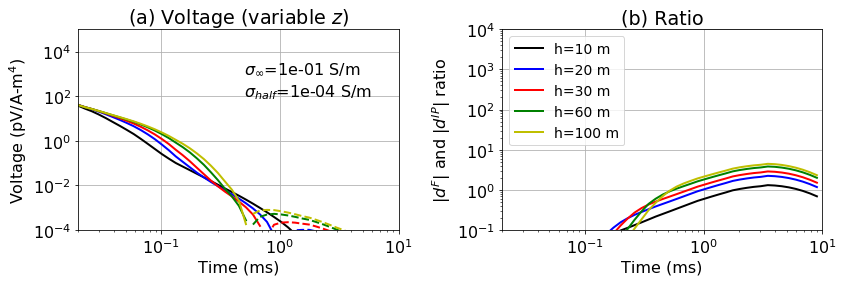

In [10]:
depths = abs(np.arange(9)*dz)
fig = plt.figure(figsize = (12, 4))
ax = plt.subplot(121)
ax1 = plt.subplot(122)
legends = [("h=%.0f m")%(dz) for dz in dzs]
ms = 1e3
colors = ["k", "b", "r", "g", 'y', 'purple', 'grey', 'skyblue', 'seagreen']
for i in range(5):
    data_p, data_n = get_dobs_pn(data_list_siginf_sig_1_r_small_h[i].flatten()/moment)
    ax.loglog(rx_emip.times*ms, data_n, linestyle='-', color=colors[i], lw=2)
    ax.loglog(rx_emip.times*ms, data_p, linestyle='--', color=colors[i], lw=2)
for i in range(5):
    ax1.loglog(rx_emip.times*ms, abs(data_ip_list_siginf_sig_1_r_small_h[i].flatten()/data_em_list_siginf_sig_1_r_small_h[i].flatten()), linestyle='-', color=colors[i], lw=2)
ax1.legend(legends, fontsize=14, loc=2)
for ax_temp in [ax, ax1]:
    ax_temp.set_xlabel("Time (ms)")        
    ax_temp.set_xlim(2e-5*ms, 0.01*ms)
    ax_temp.grid()
ax.set_ylabel("Voltage (pV/A-m$^4$)")   
ax1.set_ylabel('$|d^{F}|$ and $|d^{IP}|$ ratio')
ax.set_ylim(1e-4, 1e5)
ax1.set_ylim(1e-1, 1e4)
plt.tight_layout()    
ax.set_title("(a) Voltage (variable $z$)")
ax1.set_title("(b) Ratio")
ax.text(0.5, 1e3, ("$\sigma_{\infty}$=%.0e S/m")%(1e-1))
ax.text(0.5, 1e2, ("$\sigma_{half}$=%.0e S/m")%(1e-4))

# fig.savefig(figdir+"data_targetsize_2", dpi=300)